In [143]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.svm import LinearSVC
from mpl_toolkits.mplot3d import Axes3D
from functools import partial

In [95]:
%matplotlib notebook

In [96]:
X,y = make_classification(n_samples = 300, n_features=3, n_informative=2, n_redundant=0, 
                          n_repeated=0,n_classes=2,n_clusters_per_class=1,class_sep=0.5,
                         random_state=210)

In [97]:
df = pd.DataFrame(np.c_[X,y])
df.columns = ['x1','x2','x3','y']

<IPython.core.display.Javascript object>


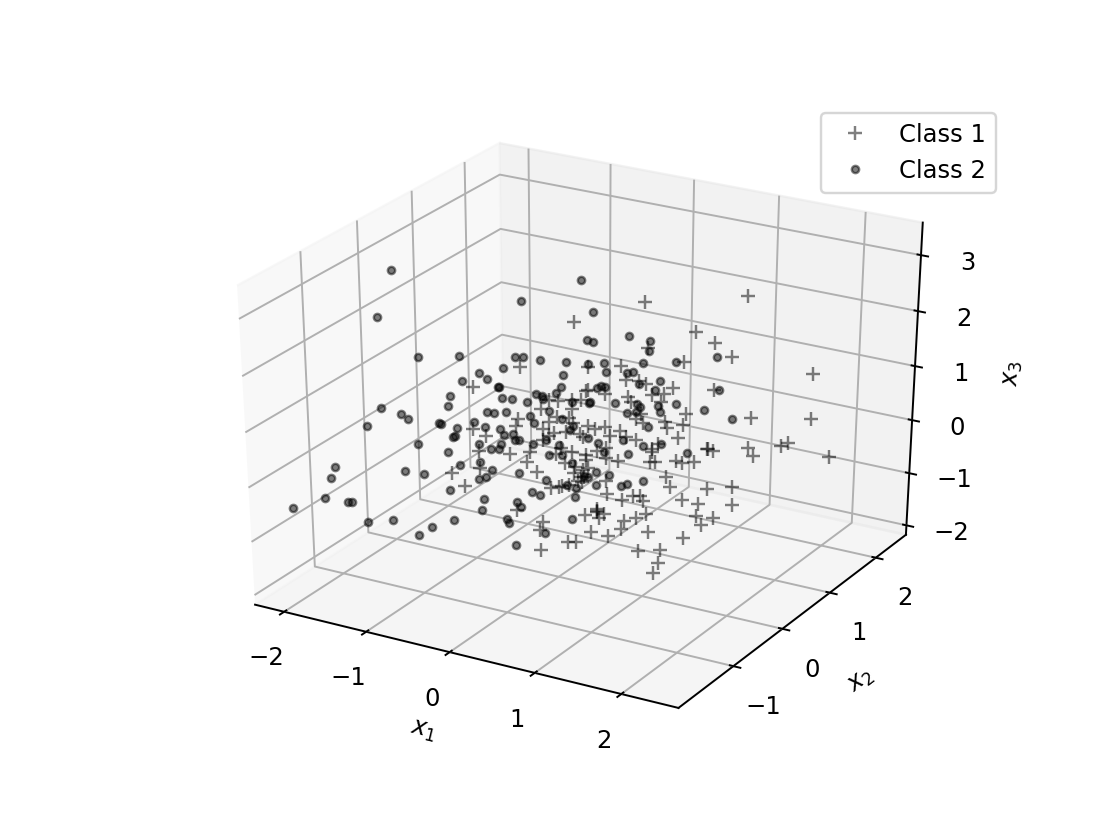

In [110]:
#Visualize dataset
c0_mask = df['y'] == 0
c1_mask = df['y'] == 1
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.plot3D(df.loc[c0_mask,'x1'],df.loc[c0_mask,'x2'],df.loc[c0_mask,'x3'],'k+', alpha=0.5, label='Class 1')
ax.plot3D(df.loc[c1_mask,'x1'],df.loc[c1_mask,'x2'],df.loc[c1_mask,'x3'],'k.',alpha=0.5, label='Class 2')
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_zlabel(r'$x_3$')
ax.legend()
plt.savefig('../figures/kfold_raw_data.png',dpi=200)
plt.show()

Assign each to the kth fold

In [103]:
#Randomize and split into K-folds
k = 3
df = df.sample(frac=1).reset_index(drop=True)
steps = np.arange(0,df.shape[0] + 1,df.shape[0]//3)
for i in np.arange(0,steps.shape[0] - 1):
    df.loc[steps[i] : steps[i+1], 'fold'] = int(i)
df['fold'] = df['fold'].astype(np.int64)

<IPython.core.display.Javascript object>


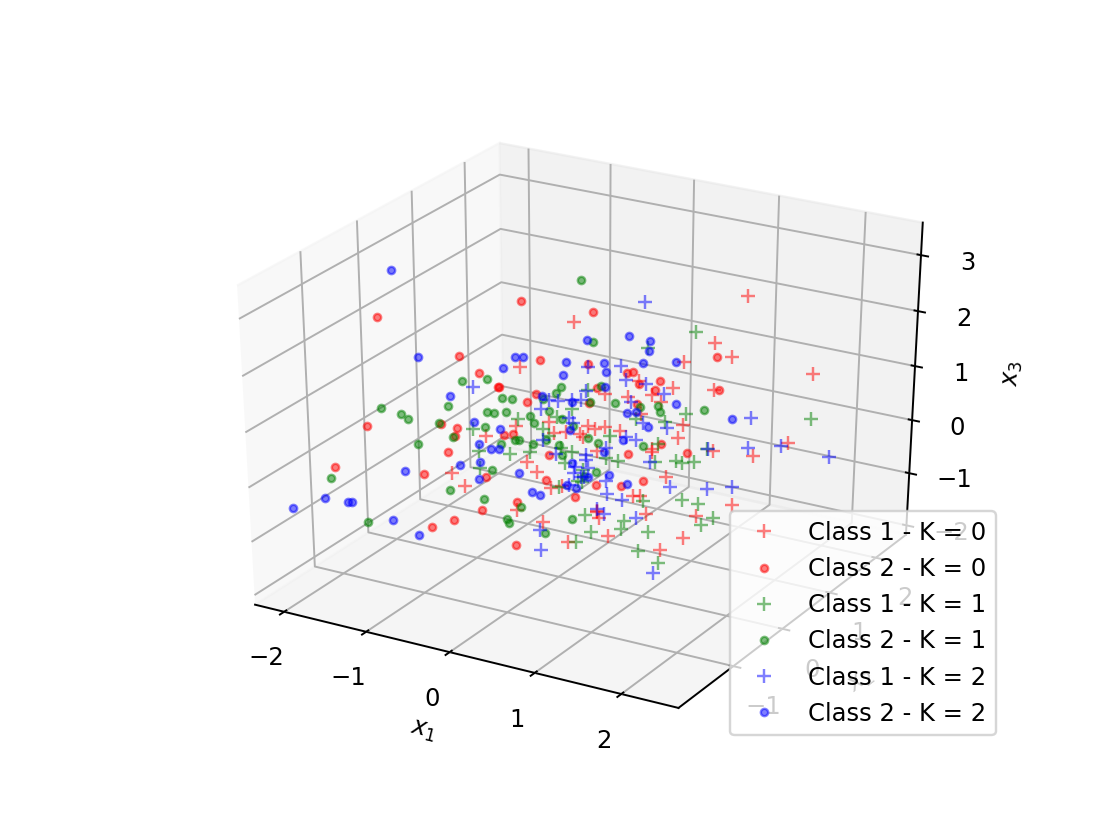

In [129]:
#Visualize dataset with re-calculated folds as masks
colors = ['r','g','b']
c0_mask = df['y'] == 0
c1_mask = df['y'] == 1
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')

for i,k in enumerate(colors):
    fold_mask = df['fold'] == i
    c0_fold = c0_mask & fold_mask
    c1_fold = c1_mask & fold_mask   
    ax.plot3D(df.loc[c0_fold,'x1'],df.loc[c0_fold,'x2'],
              df.loc[c0_fold,'x3'],'{}+'.format(k), alpha=0.5, label='Class 1 - K = {}'.format(i))
    
    ax.plot3D(df.loc[c1_fold,'x1'],df.loc[c1_fold,'x2'],
              df.loc[c1_fold,'x3'],'{}.'.format(k),alpha=0.5, label='Class 2 - K = {}'.format(i))

    ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_zlabel(r'$x_3$')
ax.legend()
plt.savefig('../figures/kfold_3fold.png',dpi=200)
plt.show()

<IPython.core.display.Javascript object>


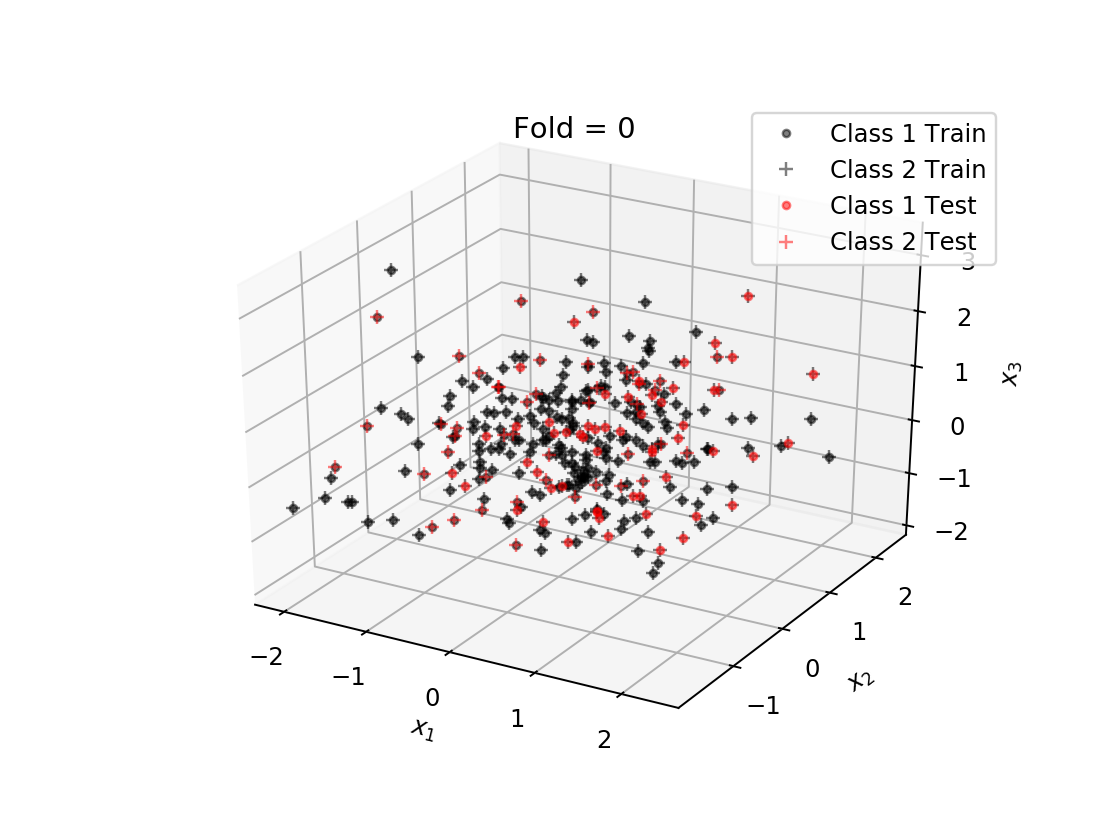

In [133]:
#Fold 0
#Visualize dataset with re-calculated folds as masks
k = 0
colors = ['r','g','b']
c0_mask = df['y'] == 0
c1_mask = df['y'] == 1
foldmask = df['fold'] == k
color = colors[k]
mask0 = foldmask & c0_mask
mask1 = foldmask & c1_mask

fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')

ax.plot3D(df.loc[~mask0,'x1'],df.loc[~mask0,'x2'],df.loc[~mask0,'x3'],'.',color='k',alpha=0.5,label='Class 1 Train')
ax.plot3D(df.loc[~mask1,'x1'],df.loc[~mask1,'x2'],df.loc[~mask1,'x3'],'+',color='k',alpha=0.5,label='Class 2 Train')
ax.plot3D(df.loc[mask0,'x1'],df.loc[mask0,'x2'],df.loc[mask0,'x3'],'.',color=color,alpha=0.5,label='Class 1 Test')
ax.plot3D(df.loc[mask1,'x1'],df.loc[mask1,'x2'],df.loc[mask1,'x3'],'+',color=color,alpha=0.5,label='Class 2 Test')

ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_zlabel(r'$x_3$')
ax.set_title('Fold = {}'.format(k))
ax.legend()
plt.savefig('../figures/kfold_{}fold.png'.format(k),dpi=200)
plt.show()

In [170]:
#Step 1: Train an SVM model using default settings
l = LinearSVC()
k = 2
testmask = df['fold'] == k
trainmask = df['fold'] != k
l.fit(df.loc[trainmask,['x1','x2','x3']],df.loc[trainmask,'y'])

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [171]:
def eval_surf(a,b,c):
    return (-c[0]*a - c[1]*b - c[3])/c[2]

partial_surf = partial(eval_surf, c = np.c_[l.coef_, l.intercept_][0])

<IPython.core.display.Javascript object>


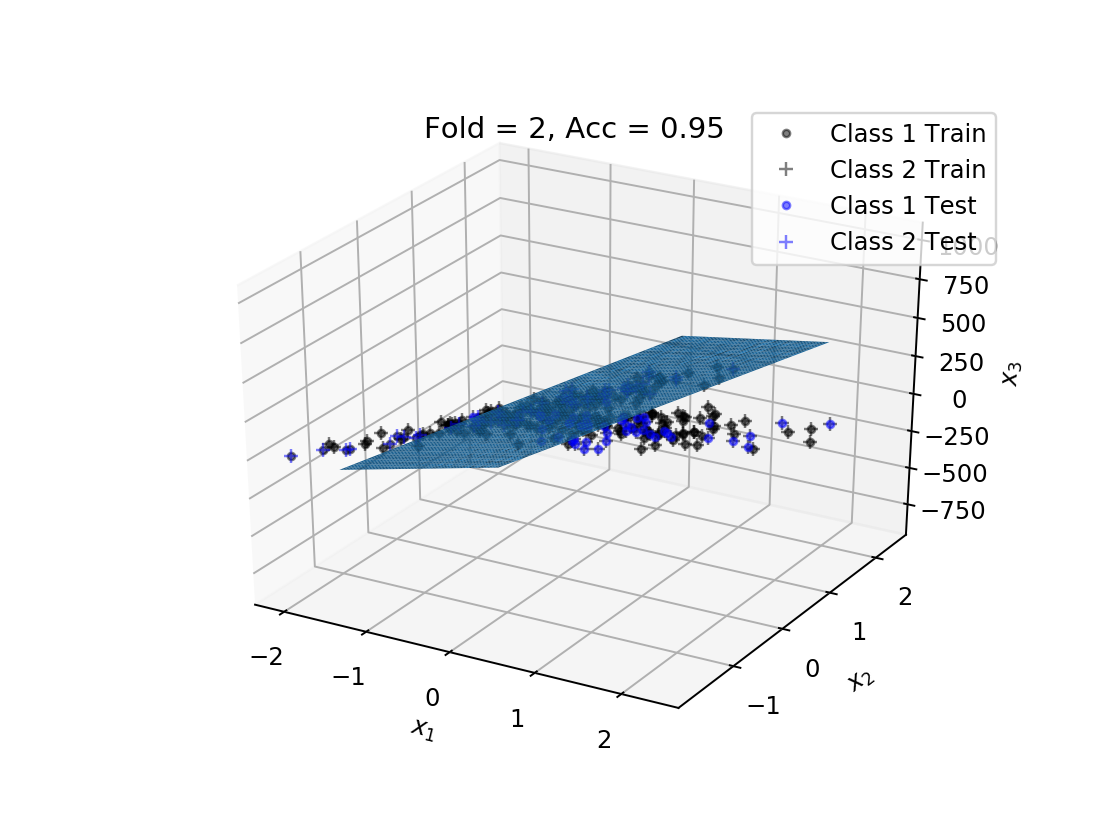

In [172]:
#Calculate error
predicts = l.predict(df.loc[testmask,['x1','x2','x3']])
pos_corr = (predicts * df.loc[testmask,'y']).sum()
neg_corr = ((1-predicts) * (1-df.loc[testmask,'y'])).sum()
acc = (pos_corr + neg_corr)/(df.loc[testmask].shape[0])

X = np.linspace(-2,2)
Y = np.linspace(-1,2)
XX,YY = np.meshgrid(X,Y)
ZZ = partial_surf(XX,YY)

#Now visualize
colors = ['r','g','b']
c0_mask = df['y'] == 0
c1_mask = df['y'] == 1
foldmask = df['fold'] == k
color = colors[k]
mask0 = foldmask & c0_mask
mask1 = foldmask & c1_mask

fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')

ax.plot3D(df.loc[~mask0,'x1'],df.loc[~mask0,'x2'],df.loc[~mask0,'x3'],'.',color='k',alpha=0.5,label='Class 1 Train')
ax.plot3D(df.loc[~mask1,'x1'],df.loc[~mask1,'x2'],df.loc[~mask1,'x3'],'+',color='k',alpha=0.5,label='Class 2 Train')
ax.plot3D(df.loc[mask0,'x1'],df.loc[mask0,'x2'],df.loc[mask0,'x3'],'.',color=color,alpha=0.5,label='Class 1 Test')
ax.plot3D(df.loc[mask1,'x1'],df.loc[mask1,'x2'],df.loc[mask1,'x3'],'+',color=color,alpha=0.5,label='Class 2 Test')
ax.plot_surface(XX,YY,ZZ)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_zlabel(r'$x_3$')
ax.set_title('Fold = {}, Acc = {}'.format(k,acc))
ax.legend()
plt.savefig('../figures/kfold_{}fold_fit.png'.format(k),dpi=200)
plt.show()